In [1]:
from utils import extract_train_test
from pathlib import Path
import pandas as pd
from model import load_trained, unidirectional, oneinner
from transformers import AutoModelForMaskedLM, AutoTokenizer
import torch

path = Path.cwd() / "good-results" / "trained-unidirectional" / "unidirectional.log"
trainset, testset = extract_train_test.train_test_datasets(path)

c:\Users\rcwyuen\OneDrive - University College London\Academic\Year 4 2023-2024\Y4 COMP0138 Dissertation\Code\TCR-Cancer-Prediction\tcr-cancer\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
modelpath = Path.cwd() / "good-results" / "trained-unidirectional" / "Epoch 20" / "classifier-20.pth"
model = load_trained(modelpath, unidirectional)
bertmodel = AutoModelForMaskedLM.from_pretrained("model/mlm-only/model").bert
tokenizer = AutoTokenizer.from_pretrained("model/mlm-only/tokenizer")
bertmodel = bertmodel.cuda() if torch.cuda.is_available() else bertmodel

model.eval()
bertmodel.eval()
model

c:\Users\rcwyuen\OneDrive - University College London\Academic\Year 4 2023-2024\Y4 COMP0138 Dissertation\Code\TCR-Cancer-Prediction\tcr-cancer\Lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


unidirectional(
  (scoring_linear1): Linear(in_features=768, out_features=1, bias=True)
  (sparsemax): Sparsemax(dim=0)
  (classifying_linear1): Linear(in_features=768, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [12]:
filepath = Path(trainset[-2])

In [13]:
if filepath.suffix == ".tsv":
    df = pd.read_csv(filepath, delimiter="\t")[["junction_aa"]]
else:
    df = pd.read_csv(filepath, header=None, usecols=[0])

df = df.dropna(axis=0, how="all")
df = df.map(lambda x: " ".join(list(x)))
df = df.apply(lambda x: "|".join(x), axis = 1)
df

0           C A S S Q D L G L S P L H F
1         C A S S L G G R R A N V L T F
2       C A S S P R L R G G Q E T Q Y F
3       C A S S P R R G L A G Y E Q Y F
4               C A S R P G N S P L H F
                     ...               
9040            C S V F L G P H L Q Y F
9041      C S V E R G Q I D F N E Q F F
9042    C A S S S D R P E S Y N E Q F F
9043        C S A I G G T G V D E Q Y F
9044    C A S S P P G I L Q S Y E Q Y F
Length: 9045, dtype: object

In [14]:
from utils.dataloader import TCRloader
from tqdm.notebook import tqdm
import numpy as np

pattcr_loader = torch.utils.data.DataLoader(
    TCRloader(None, df).data,
    batch_size=128,
    shuffle=True,
)

all_embeddings = []
for tcr in tqdm(pattcr_loader):
    inputs = tokenizer(tcr, return_tensors="pt", padding=True)

    if torch.cuda.is_available():
        inputs = {k: v.to("cuda") for k, v in inputs.items()}

    embeddings = bertmodel(**inputs).last_hidden_state
    embeddings = torch.mean(embeddings, dim=1)
    all_embeddings = all_embeddings + embeddings.tolist()

all_embeddings = torch.from_numpy(np.array(all_embeddings)).to(torch.float32)
all_embeddings = all_embeddings.cuda() if torch.cuda.is_available() else all_embeddings
print (all_embeddings.shape, df.shape)


  0%|          | 0/71 [00:00<?, ?it/s]

torch.Size([9045, 768]) (9045,)


In [15]:
all_embeddings[0].squeeze().cpu().detach().numpy()[:5:]

array([ 0.05796139, -0.692268  , -0.17248143,  0.68266463,  1.0991328 ],
      dtype=float32)

In [16]:
prediction = model(all_embeddings)
truelabel = int("cancer" in str(filepath))

print (f"Cancer Probability: {prediction.item()}")
print (f"True Label        : {truelabel}")

Cancer Probability: 0.9040498733520508
True Label        : 1


In [17]:
scores = model.last_scores.squeeze().cpu().detach().numpy()
print (scores)

[-2.003206   0.7738294 -1.894045  ... -0.61249   -0.7744212 -2.2165408]


In [18]:
weights = model.last_weights.squeeze().cpu().detach().numpy()
print (weights)

[0. 0. 0. ... 0. 0. 0.]


In [19]:
np.count_nonzero(weights)

4

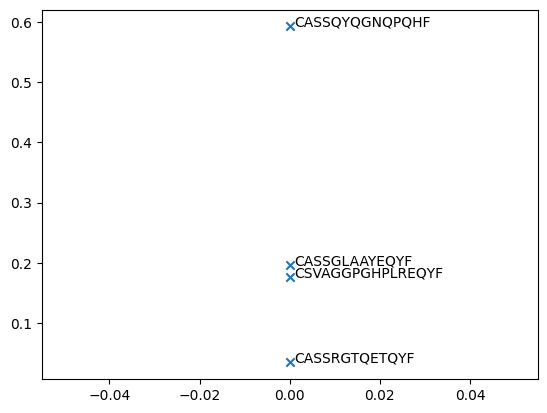

In [25]:
import matplotlib.pyplot as plt

plt.scatter([0 for i in range(np.count_nonzero(weights))], weights[np.where(weights != 0)], marker = "x")

for i in np.where(weights != 0)[0]:
    plt.annotate(df.iloc[i].replace(" ", ""), (0.001, weights[i]))

plt.show()